# A-B Testing

A/B testing: Utilizando el endpoint de predicción y el conjunto de datos
“futuros”, divididos aleatoriamente en 7 días de la semana, simule un escenario en
donde se hagan solicitudes a dicho endpoint mientras aleatoriamente en una
proporción de 50%/50% se varía la versión del modelo (punto 2 y 3) utilizada para
la generación de la predicción.

NOTA: La ejecución de este notebook supone que se está ejecutando el servicio de API en el servidor local, ejecutando: 
```bash
> pip install -r requierements.txt
> cd API
> uvicorn main:app
```

In [1]:
import requests
import pandas as pd
import random
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp


sns.set()

In [2]:
API_HOST = "http://localhost:8000"

In [3]:
# Verificamos que la API está funcionando:
req = requests.get(f"{API_HOST}/")
req.json()

[{'message': 'Hello world'}]

Leemos los datos

In [4]:
with open("Dataset/churn_future.json", "rt") as f:
    data = json.load(f)

Asignamos cada registro a un día de la semana en forma aleatoria.

(esta instrucción en el taller no es muy clara, pero entendemos que para el ejercicio se debe suponer que los registros corresponden a 7 días y que debemos asignarlos de forma aleatoria)

In [5]:
df = pd.DataFrame({"datos": data})
df["día"] = np.random.randint(1,8, len(df))
df = df.sort_values("día")

df.head()

,datos,día
665,"{'customerID': '5876-HZVZM', 'gender': 'Female...",1
666,"{'customerID': '1400-MMYXY', 'gender': 'Male',...",1
187,"{'customerID': '9036-CSKBW', 'gender': 'Female...",1
192,"{'customerID': '7439-DKZTW', 'gender': 'Male',...",1
194,"{'customerID': '4607-CHPCA', 'gender': 'Male',...",1


In [6]:
def predict(registro):
    """ llama a la API seleccionando una versión de forma aleatoria"""
    
    # Elegimos aleatóriamente qué versión de la API utilizar:
    api_version = random.choice([1, 2])

    # Hacemos una solicitud a la API
    req = requests.post(f"{API_HOST}/{api_version}/predict", json=[registro])
    
    # Verificamos que la API haya respondido correctamente:
    if req.status_code == 200:
        # Devolvemos la probabilidad de la clase positica
        pred = req.json()[0]
        return pd.Series({"api_version": api_version,  "probabilidad de churn": pred['1']})
    else:
        return pd.Series({"api_version": api_version,  "probabilidad de churn": np.nan})
    
df[['api_version', 'probabilidad de churn']] = df["datos"].apply(predict)

df.head()

,datos,día,api_version,probabilidad de churn
665,"{'customerID': '5876-HZVZM', 'gender': 'Female...",1,1.0,0.276290
666,"{'customerID': '1400-MMYXY', 'gender': 'Male',...",1,1.0,0.468228
187,"{'customerID': '9036-CSKBW', 'gender': 'Female...",1,2.0,0.395080
192,"{'customerID': '7439-DKZTW', 'gender': 'Male',...",1,1.0,0.639634
194,"{'customerID': '4607-CHPCA', 'gender': 'Male',...",1,2.0,0.367523


In [7]:
# Se eliminan algunos registros nulos, que se producen porque algunos datos están incorrectamente codificados
df = df.dropna()

Asumiendo que el threshold óptimo para asignar la
etiqueta churn o no churn es 0.5, responda a las preguntas:

**a. Para toda la ventana de tiempo, ¿cómo se distribuyen las probabilidades
asignadas por el modelo entre los dos grupos? Asumiendo que las
distribuciones tienen un comportamiento normal, ¿dichas diferencias entre
las probabilidades de ambas variantes del modelo son significativ**as?


<Axes: xlabel='api_version', ylabel='probabilidad de churn'>

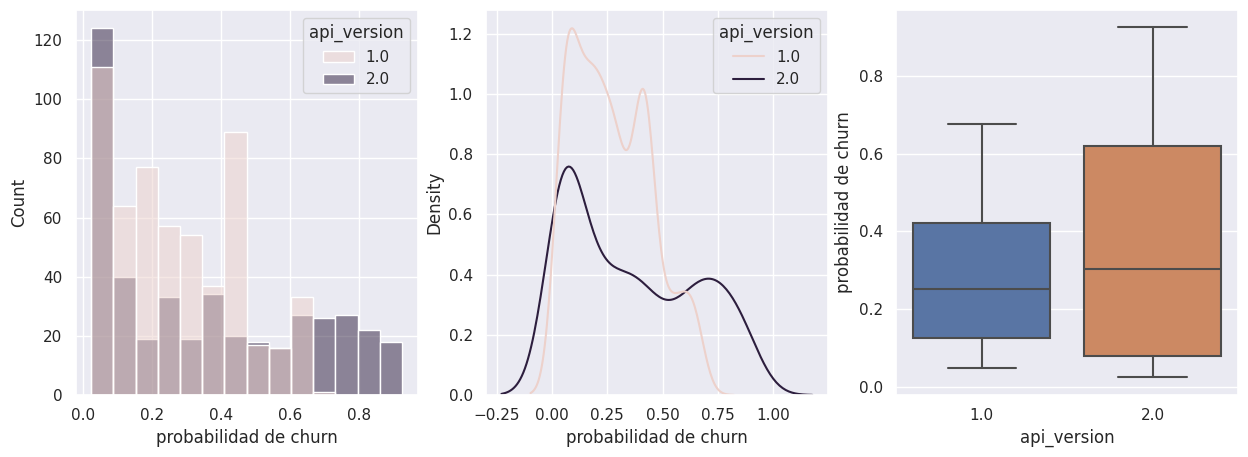

In [8]:
_, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
sns.histplot(df, x="probabilidad de churn", hue="api_version", ax=ax1)
sns.kdeplot(df, x="probabilidad de churn", hue="api_version", ax=ax2)
sns.boxplot(df, y="probabilidad de churn", x="api_version", ax=ax3)


Como se aprecia en la gráfica anterior, la versión 1 tiende a asignar una probabilidad menor de chorn y tiene una mayor concentración en probabilidades cercanas a 0.4, lo que probablemente se debe a su dificultad para discriminar las dos clases.

In [9]:
ttest_ind(
    df.loc[df['api_version'] == 1, "probabilidad de churn"],
    df.loc[df['api_version'] == 2, "probabilidad de churn"],
    equal_var=False
)

TtestResult(statistic=-5.512746508805951, pvalue=4.998593058992957e-08, df=688.581710181521)

De la prueba anterior podemos concluir que existe una diferencia significativa entre las medias de las probabilidades predichas por los dos modelos.

**b. ¿Cuál fue el incremento o decremento porcentual diario de predicción de
casos de churn que tuvo el mejor modelo (punto 3) respecto al baseline
(punto 2)?**

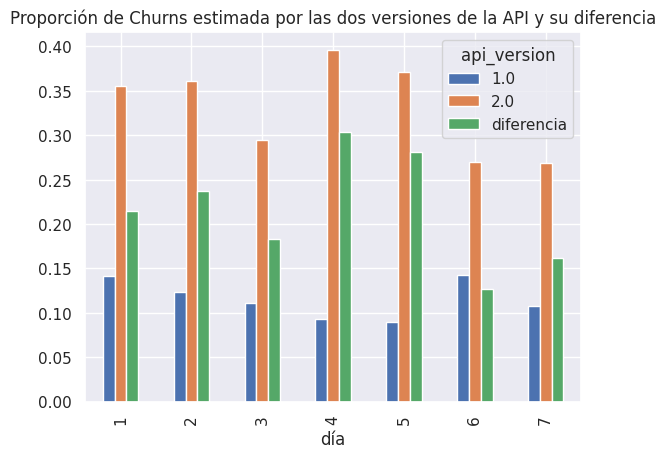

In [10]:
# Calculamos el porcentaje de Churns predichos: 
variacion_diaria = (
    df
    .assign(churn = lambda x: x["probabilidad de churn"] > 0.5)
    .groupby(["día", "api_version"])['churn']
    .mean()
    .unstack()
    .assign(diferencia=lambda x: x[2]- x[1])
    .plot.bar(title="Proporción de Churns estimada por las dos versiones de la API y su diferencia")
)

Como se observa en la gráfica anterior, para todos los días de la semana la versión 2 de la API estima una proporción mayor de Chorns.

**c. En una base diaria, ¿cuál fue el porcentaje de éxito del modelo prediciendo
casos de efectivos de churn?**

In [11]:
# Extraemos del diccionario el valor real de chorn y el predicho
df['churn'] = np.where(df['datos'].str['Churn'] == "Yes", 1, 0)

df['churn_predicho'] = np.where(df['probabilidad de churn'] > 0.5, 1, 0)

df.head()

,datos,día,api_version,probabilidad de churn,churn,churn_predicho
665,"{'customerID': '5876-HZVZM', 'gender': 'Female...",1,1.0,0.276290,1,0
666,"{'customerID': '1400-MMYXY', 'gender': 'Male',...",1,1.0,0.468228,1,0
187,"{'customerID': '9036-CSKBW', 'gender': 'Female...",1,2.0,0.395080,0,0
192,"{'customerID': '7439-DKZTW', 'gender': 'Male',...",1,1.0,0.639634,0,1
194,"{'customerID': '4607-CHPCA', 'gender': 'Male',...",1,2.0,0.367523,1,0


Con esta información podemos calcular algunas métricas para evaluar el desempeño de los dos modelos

In [12]:
from sklearn.metrics import classification_report

# Modelo v1
print("****** Versión 1 ********")
print(classification_report(
    df.loc[df['api_version'] == 1, 'churn'], 
    df.loc[df['api_version'] == 1, 'churn_predicho'], 
))

print("\n\n****** Versión 2 ********")
print(classification_report(
    df.loc[df['api_version'] == 2, 'churn'], 
    df.loc[df['api_version'] == 2, 'churn_predicho'], 
))

****** Versión 1 ********
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       412
           1       0.62      0.28      0.38       144

    accuracy                           0.77       556
   macro avg       0.71      0.61      0.62       556
weighted avg       0.75      0.77      0.74       556



****** Versión 2 ********
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       322
           1       0.60      0.72      0.65       121

    accuracy                           0.79       443
   macro avg       0.74      0.77      0.75       443
weighted avg       0.81      0.79      0.80       443



De las métricas anteriores podemos concluir que en el **modelo v1**:
- De todos los churns clasificó correctamente al 28% (recall).
- De todos los individuos clasificados como Churn el 62% efectivamente lo eran (precision).
- En el 77% de los casos la clasificación fue correcta (accuracy).

De las métricas anteriores podemos concluir que en el **modelo v2**:
- De todos los churns clasificó correctamente al 72% (recall)
- De Todos los individuos clasificados como Churn el el 62% efectivamente lo eran (precision)
- En el 79% de los casos la clasificación fue correcta (accuracy)

Finalmente, tomando **F1**, que ha sido nuestra métrica objetivo (que toma un promedio ármonico del racall y la precisión) podemos observar que la versión 2 del modelo es claramente superior. Lo cual se suma a la mejora sustancial en el recall y a solo una pequeña disminución de la precisión.  

Esto llevado a una base diaria tendría el siguiente comportamiento

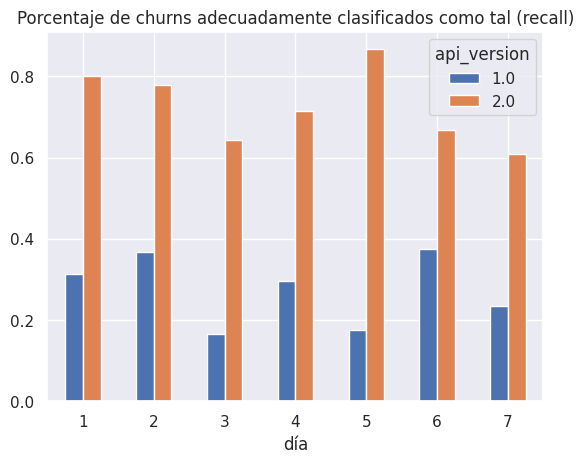

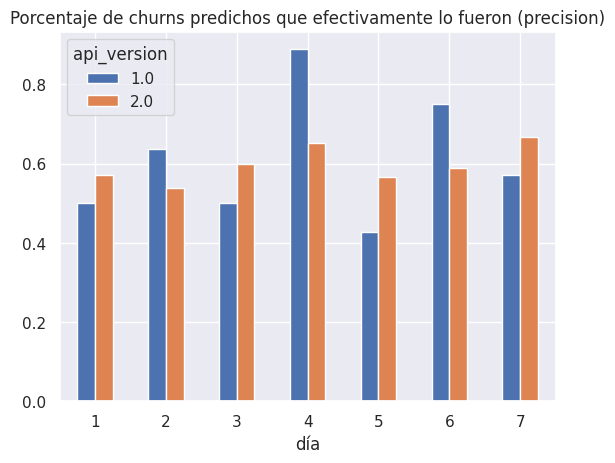

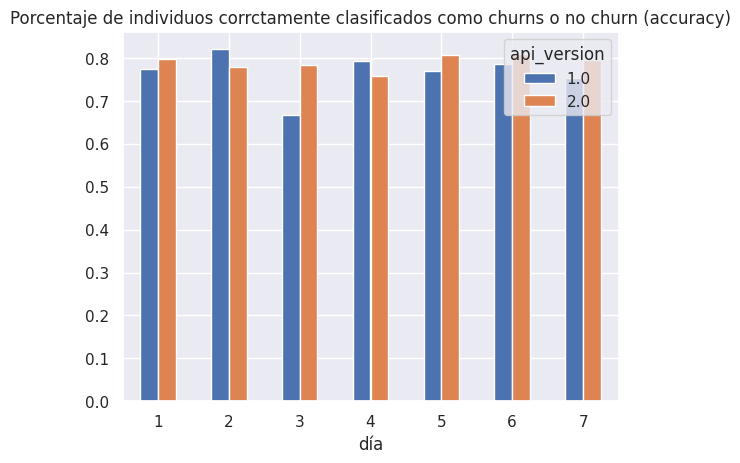

In [13]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
(
    df
    .groupby(['día', 'api_version'])
    .apply(lambda x: recall_score(x['churn'], x['churn_predicho']))
    .unstack()
    .plot.bar(title = "Porcentaje de churns adecuadamente clasificados como tal (recall)", rot=0)
);

(
    df
    .groupby(['día', 'api_version'])
    .apply(lambda x: precision_score(x['churn'], x['churn_predicho']))
    .unstack()
    .plot.bar(title = "Porcentaje de churns predichos que efectivamente lo fueron (precision)", rot=0)
);

(
    df
    .groupby(['día', 'api_version'])
    .apply(lambda x: accuracy_score(x['churn'], x['churn_predicho']))
    .unstack()
    .plot.bar(title = "Porcentaje de individuos corrctamente clasificados como churns o no churn (accuracy)", rot=0)
);

A nivel diario podemos observar que la suporioridad del **modelo v2** se mantiene en el recall para todos los días, aunque las demás métricas la ventaja no es tan contundente. 